In [1]:
import os
import sys
project_path = os.path.expanduser('~/emg2qwerty')
sys.path.append(project_path)

from emg2qwerty.data import EMGSessionData, LabelData, WindowedEMGDataset
import numpy as np
import torch

# Exploring data class

In [2]:
hdf5_dir = os.path.join(project_path, 'data') 
filename = os.listdir(hdf5_dir)[0]
hdf5_path = os.path.join(hdf5_dir, filename)

data = EMGSessionData(hdf5_path)
window = WindowedEMGDataset(hdf5_path)

In [3]:
data.duration_mins * 60, data.timeseries.shape[0] / 2000 # Note that the sampling rate is 2000 Hz

(1442.9206147193909, 1442.888)

In [5]:
print(f"Filename: {filename}")

item = data.__getitem__(0)  # Get the first sample
print(f"Shape: {item.shape}")

length = data.__len__()
print(f"Length: {length}")

GT = data.ground_truth(start_t = 0, end_t = np.inf)
print(f"GT: {(GT.labels.shape)}")

# print(GT.labels) # This labels characters as numbers (axcii)
# print(len(GT.__str__())) # This is the actual alphabet output

timestamp = data.timestamps
timestep = np.diff(timestamp)
print(f"timestamps: {(timestamp.shape)}")
print(f"timestep : {timestep[0:3]} ..., Maximum time in between : {np.max(timestep)}")

keystroke = data.keystrokes
print(f"keystroke: {len(keystroke)}")
print(f"keystroke format : {keystroke[0]}")

# Keystroke and GT have different length <- This was capslock
from collections import Counter
GT_str = list(Counter(GT.__str__()).keys())
keystroke_str = list(Counter([key['key'] for key in keystroke]).keys())
print([key for key in keystroke_str if key not in GT_str])
print(f"Pressed caps lock for {Counter([key['key'] for key in keystroke])['Key.caps_lock']} times")

print(f"Duration : {data.duration_mins * 60}")

Filename: 2021-07-24-1627142755-keystrokes-dca-study@1-235fe8d6-9339-48e9-b67e-7105d7294d9e.hdf5
Shape: ()
Length: 2885776
GT: (4393,)
timestamps: (2885776,)
timestep : [0.00049996 0.00049996 0.00049996] ..., Maximum time in between : 0.0005500316619873047
keystroke: 4397
keystroke format : {'ascii': 116, 'key': 't', 'start': 1627142759.1450353, 'end': 1627142759.1880355}
['Key.space', 'Key.backspace', 'Key.enter', 'Key.caps_lock']
Pressed caps lock for 4 times
Duration : 1442.9206147193909


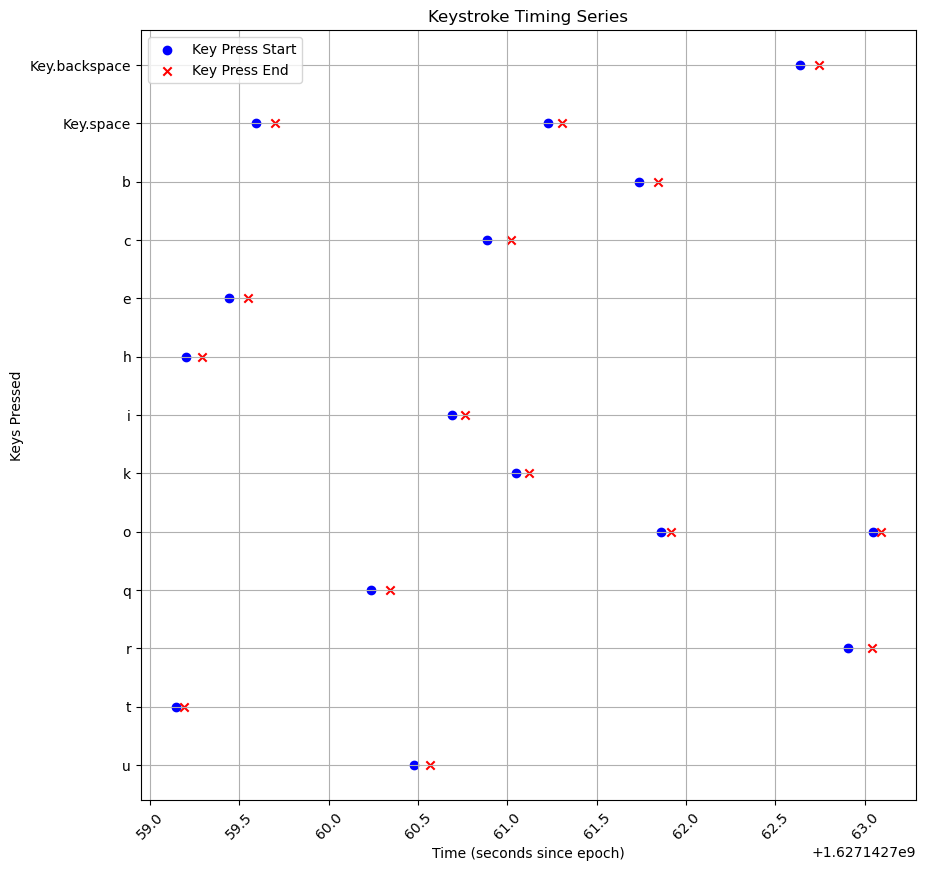

In [5]:
import matplotlib.pyplot as plt
import pandas as pd


# Convert keystroke data into DataFrame
df = pd.DataFrame(keystroke[0:15])
df = df.sort_values(by="key", ascending=False)


# Plot timeseries of keystroke timings
plt.figure(figsize=(10, 10))
plt.scatter(df["start"], df["key"], marker='o', color='b', label="Key Press Start")
plt.scatter(df["end"], df["key"], marker='x', color='r', label="Key Press End")

plt.xlabel("Time (seconds since epoch)")
plt.ylabel("Keys Pressed")
plt.title("Keystroke Timing Series")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Perform Inference

In [6]:
# Import test data
import yaml
user_name = 'user0'

yaml_path = os.path.expanduser(f'~/emg2qwerty/config/user/{user_name}.yaml')
yaml = yaml.safe_load(open(yaml_path, 'r'))
session_list = yaml['dataset']['test']

# Later, we will need to iterate
# for session in session_list:
#     filename = session['session']
filename = session_list[0]['session']

filename = os.listdir(hdf5_dir)[0]
hdf5_path = os.path.join(hdf5_dir, filename)    

data = EMGSessionData(hdf5_path)
GT = data.ground_truth()

# Import the personalized model for the user
from emg2qwerty.lightning import TDSConvCTCModule
model_path = os.path.expanduser(f'~/emg2qwerty/models/personalized-finetuned/{user_name}.ckpt')
model = TDSConvCTCModule.load_from_checkpoint(model_path)

In [7]:
from emg2qwerty import transforms
# Convert the input data into desired shape for the model
to_tensor = transforms.ToTensor()
input = to_tensor.__call__(data)
print("original shape:", input.shape)

transform = transforms.LogSpectrogram()
input_transformed = transform.__call__(input)
print("transformed shape:", input_transformed.shape) # <- T got smaller: 2885776 -> 180358
# Formula : (original - n_fft)/hop_length + 1

# Add in dimension for batch
input_transformed = input_transformed.unsqueeze(1)
input_transformed.shape
print("batch inserted shape:", input_transformed.shape)

original shape: torch.Size([2885776, 2, 16])
transformed shape: torch.Size([180358, 2, 16, 33])
batch inserted shape: torch.Size([180358, 1, 2, 16, 33])


In [8]:
# Perform inference with the built in method (test_step) <- Apparently this has decoder inside ... ?

batch = {
    "inputs": input_transformed,
    "targets": GT.labels.reshape(-1, 1),
    "input_lengths": np.array([input_transformed.shape[0]]).reshape(-1),
    "target_lengths": np.array([GT.labels.shape[0]]).reshape(-1)
}

pred = model.test_step(batch, decoder = 'ctc_beam')

TypeError: ctc_loss() received an invalid combination of arguments - got (Tensor, numpy.ndarray, numpy.ndarray, numpy.ndarray, int, int, bool), but expected one of:
 * (Tensor log_probs, Tensor targets, tuple of ints input_lengths, tuple of ints target_lengths, int blank, int reduction, bool zero_infinity)
      didn't match because some of the arguments have invalid types: (Tensor, !numpy.ndarray!, !numpy.ndarray!, !numpy.ndarray!, int, int, bool)
 * (Tensor log_probs, Tensor targets, Tensor input_lengths, Tensor target_lengths, int blank, int reduction, bool zero_infinity)
      didn't match because some of the arguments have invalid types: (Tensor, !numpy.ndarray!, !numpy.ndarray!, !numpy.ndarray!, int, int, bool)


In [9]:
# Perform inference with the forward pass myself
model.eval()
pred = model.forward(input_transformed)
pred = pred.detach().cpu()

print("shape after forward pass :", pred.shape)
# I need to do something differently... prediction shrinks T again...
# Plus, I need to convert the output length into original shape

: 

: 

In [ ]:
# Use module to load test data
from emg2qwerty.lightning import WindowedEMGDataModule
from collections.abc import Sequence
from emg2qwerty.transforms import Transform
from pathlib import Path

module_config = {
    'window_length': 10,
    'padding': (10,10),
    'batch_size': 1,
    'num_workers': 5,
    'train_sessions': [Path(hdf5_path)],
    'val_sessions': [Path(hdf5_path)],
    'test_sessions': [Path(hdf5_path)],
    'train_transform': Transform[np.ndarray, torch.Tensor],
    'val_transform': Transform[np.ndarray, torch.Tensor],
    'test_transform': Transform[np.ndarray, torch.Tensor],}
window_module = WindowedEMGDataModule(**module_config)
window_module.setup()
data_loader = window_module.test_dataloader()

In [ ]:
# Convert the output into readable format
from emg2qwerty.charset import CharacterSet
chars = CharacterSet()
print("num_classes :", chars.num_classes)
print("example output : idx = 97 =>",chars.label_to_key(97))
# NOTE chars.num_classes include null-class (blank label).
# Index 98 is the blank label
blank_idx = chars.null_class
print("blank_idx :", blank_idx)

In [ ]:
from emg2qwerty.metrics import CharacterErrorRates
cer = CharacterErrorRates()
cer.update(pred, GT.labels)

In [ ]:
import torchaudio.functional as F
import torch
import numpy as np

n_fft = 64
hop_length = 16
win_length = n_fft
n_iter = 32  # Number of iterations for phase estimation

# Ensure pred is a tensor
if isinstance(pred, np.ndarray):
    pred = torch.tensor(pred, dtype=torch.float32)

# Convert log-spectrogram back to linear scale
pred_linear = torch.pow(10, pred)

# Ensure correct shape (freq dimension should be n_fft // 2 + 1)
expected_freq_bins = (n_fft // 2) + 1
if pred_linear.shape[1] != expected_freq_bins:
    raise ValueError(f"Expected {expected_freq_bins} frequency bins, but got {pred_linear.shape[1]}")

# Create a Hann window function (commonly used for STFT)
window = torch.hann_window(win_length)

# Use Griffin-Lim algorithm to estimate phase and reconstruct time-domain signal
recovered_signal = F.griffinlim(
    specgram=pred_linear,
    window=window,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    power=1.0,  # Since we already converted from log scale
    n_iter=n_iter,  # Number of iterations for phase reconstruction
    momentum=0.99,  # Helps stabilize phase estimation
    length=None,  # Can be set if you know the original time length
    rand_init=True  # Starts with random phase
)
